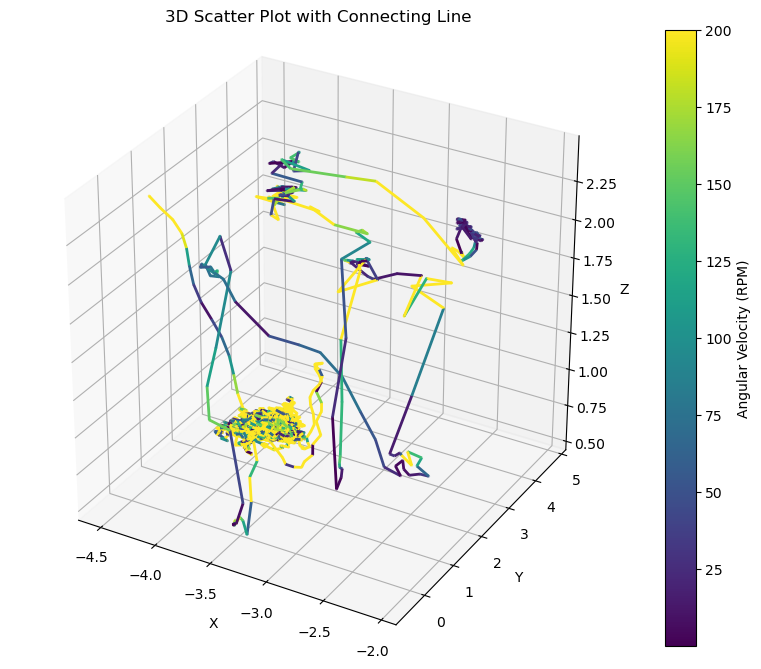

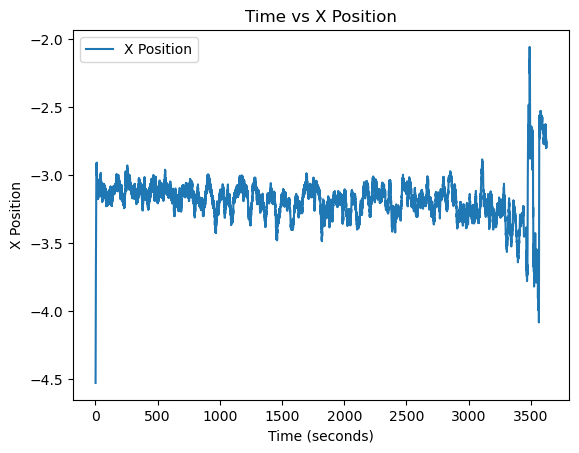

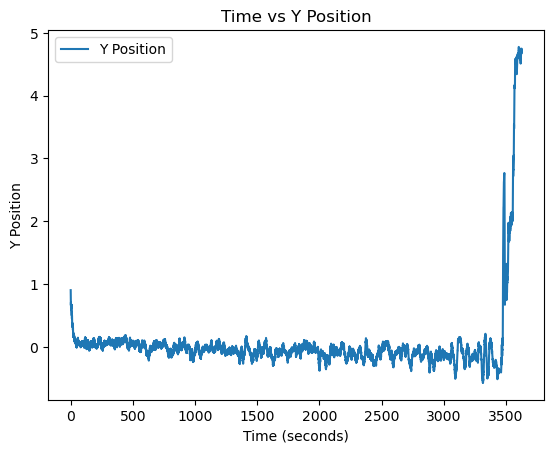

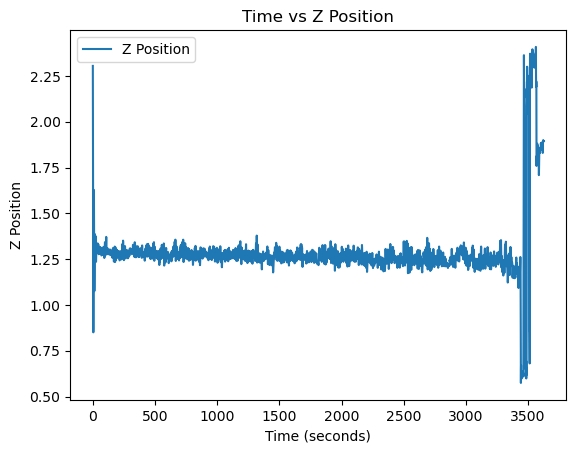

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from scipy.interpolate import CubicSpline

# Read the CSV file into a pandas DataFrame with delimiter as ' '
csv_file_path = "/Users/leonardo/Documents/Jupyter_Notebook_Workspace/Tracking_Data_Plotting/globalTrack1690821639.7140338_.csv"
df = pd.read_csv(csv_file_path, delimiter=' ')

# Smoothing function to apply moving average filter to the 'yaw' data column
def smooth_yaw(yaw_data, window_size=5):
    return np.convolve(yaw_data, np.ones(window_size) / window_size, mode='valid')

# Apply smoothing to 'yaw' data (set smoothing_on to True to enable)
smoothing_on = True
if smoothing_on:
    # Calculate the smoothed yaw data and align with the original DataFrame
    smoothed_yaw = smooth_yaw(df['yaw'])
    df = df.iloc[(len(df) - len(smoothed_yaw)):]
    df['yaw'] = smoothed_yaw

# Convert rate of change of yaw to angular velocity in rotations per minute (RPM)
df['angular_velocity'] = np.gradient(df['yaw'], df['time']) * 60 / (2 * np.pi)

# Ensure non-negative RPM values
df['angular_velocity'] = df['angular_velocity'].abs()

# Cap the angular velocity at a reasonable limit (e.g., 200 RPM)
max_angular_velocity = 200
df['angular_velocity'] = df['angular_velocity'].clip(upper=max_angular_velocity)

# Create 3D Scatter plot with line connecting data points in red
def plot_3d_scatter_line(show_scatter_dots=True, show_line=True, marker_size=30, color_line_by_velocity=True):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    if show_scatter_dots:
        # Scatter plot with color based on angular velocity
        sc = ax.scatter(df['x'], df['y'], df['z'], c=df['angular_velocity'], cmap='viridis', s=marker_size)
        cbar = fig.colorbar(sc, ax=ax)
        cbar.set_label('Angular Velocity (RPM)')

    if show_line:
        if color_line_by_velocity and show_scatter_dots:
            # Create a Cubic Spline interpolation for the smoothed yaw data
            tck = CubicSpline(df['time'], df['yaw'])

            # Generate finer time points for a smoother line
            t_smooth = np.linspace(df['time'].min(), df['time'].max(), 500)
            yaw_smooth = tck(t_smooth)

            # Line connecting the data points with color based on angular velocity
            segments = np.array([df['x'], df['y'], df['z']]).T.reshape(-1, 1, 3)
            segments = np.concatenate([segments[:-1], segments[1:]], axis=1)
            lc = Line3DCollection(segments, cmap='viridis', linewidths=2)
            lc.set_array(df['angular_velocity'])
            ax.add_collection3d(lc)
        else:
            # Line connecting the data points with a solid color (red)
            points = np.array([df['x'], df['y'], df['z']]).T.reshape(-1, 1, 3)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = Line3DCollection(segments, colors='red', linewidths=2)
            ax.add_collection3d(lc)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Scatter Plot with Connecting Line')

    # Adjust aspect ratio to make the plot more spacious
    ax.set_box_aspect([1, 1, 1])  # Set the aspect ratio to 'auto'

    # Export 3D plot to JPEG
    plt.savefig('3d_scatter_plot.jpg', dpi=300)

    plt.show()

# Plot time vs x, time vs y, and time vs z separately
def plot_time_vs_axis(axis):
    fig, ax = plt.subplots()
    ax.plot(df['time'], df[axis])
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel(f'{axis.upper()} Position')
    ax.set_title(f'Time vs {axis.upper()} Position')
    plt.legend([f'{axis.upper()} Position'])

    # Export plot to JPEG
    plt.savefig(f'{axis}_position_plot.jpg', dpi=300)

    plt.show()

# Plot the 3D scatter plot with the option to turn on/off scatter dots and line color choice
plot_3d_scatter_line(show_scatter_dots=True, show_line=True, marker_size=1, color_line_by_velocity=True)

# Plot the separate time vs axis plots
plot_time_vs_axis('x')
plot_time_vs_axis('y')
plot_time_vs_axis('z')

